In [7]:
from datetime import datetime
from math import exp
from collections import defaultdict

# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.special import expit, logit
from scipy.stats.mstats import winsorize
from scipy.interpolate import interp1d, make_interp_spline, BSpline

# Plot data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from IPython.display import HTML, Image, display, Markdown as md

# statsmodels
import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# scikit-learn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import r2_score, mean_squared_error

# tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# warnings
import warnings
warnings.filterwarnings('ignore')

md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

Analysis last performed on 06/14/2022.

## Read `Auto` dataset

In [8]:
# SOURCE: https://www.tensorflow.org/tutorials/keras/regression

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

auto_raw = pd.read_csv(url, names=column_names, 
                       na_values='?', comment='\t', 
                       sep=' ', skipinitialspace=True)
auto_raw

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [9]:
auto = auto_raw.copy()
auto.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Check data types and values

In [10]:
auto.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

## Clean the data

In [11]:
# SOURCE: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

auto = auto.copy()

auto['Horsepower'] = auto.loc[:, 'Horsepower'].replace('?', np.nan)

auto = auto.dropna()

auto['Horsepower'] = auto.loc[:, 'Horsepower'].astype('int')

auto

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504.0,12.0,70,1
1,15.0,8,350.0,165,3693.0,11.5,70,1
2,18.0,8,318.0,150,3436.0,11.0,70,1
3,16.0,8,304.0,150,3433.0,12.0,70,1
4,17.0,8,302.0,140,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790.0,15.6,82,1
394,44.0,4,97.0,52,2130.0,24.6,82,2
395,32.0,4,135.0,84,2295.0,11.6,82,1
396,28.0,4,120.0,79,2625.0,18.6,82,1


The `"Origin"` column is categorical, not numeric.  So the next step is to one-hot encode the values in the column with `pd.get_dummies`.

In [12]:
auto['Origin'] = auto['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

auto = pd.get_dummies(auto, columns=['Origin'], prefix='', prefix_sep='')
auto.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82,2720.0,19.4,82,0,0,1


In [13]:
auto.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Europe          0
Japan           0
USA             0
dtype: int64

## Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [14]:
train_auto = auto.sample(frac=0.8, random_state=0)
test_auto = auto.drop(train_auto.index)

## Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

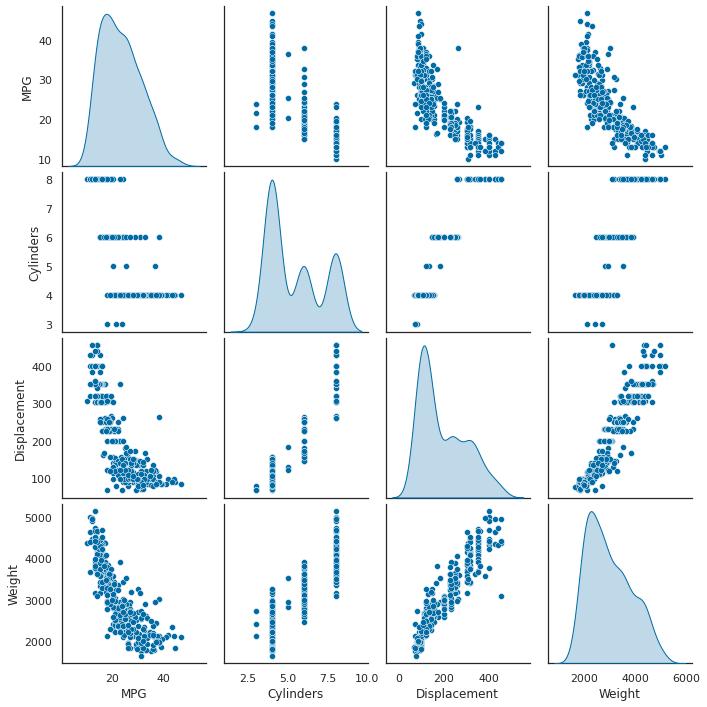

In [ ]:
sns.pairplot(train_auto[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Let's also check the overall statistics. Note how each feature covers a very different range:

In [ ]:
train_auto.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.31,7.73,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.48,1.70,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.32,104.33,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.87,38.10,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.25,843.90,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.56,2.79,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.90,3.68,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.18,0.38,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.20,0.40,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.62,0.49,0.0,0.00,1.0,1.00,1.0


## Split features from labels

Separate the target value — the "label" — from the features.  This label is the value that you will train the model to predict.

In [15]:
train_features = train_auto.copy()
test_features = test_auto.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.columns.to_list()

['Cylinders',
 'Displacement',
 'Horsepower',
 'Weight',
 'Acceleration',
 'Model Year',
 'Europe',
 'Japan',
 'USA']

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [16]:
train_auto.describe().transpose()[['mean', 'std']].round(2)

,mean,std
MPG,23.31,7.73
Cylinders,5.48,1.70
Displacement,195.32,104.33
Horsepower,104.87,38.10
Weight,2990.25,843.90
Acceleration,15.56,2.79
Model Year,75.90,3.68
Europe,0.18,0.38
Japan,0.20,0.40
USA,0.62,0.49


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity.

# Exercise:

## 1. Standardize both the (a) `train_features` and the (b) `test_features` 
## (i.e. for each column, subtract its mean and divide by its standard deviation)

### with `pandas`

In [ ]:
# standardize train_features


In [ ]:
# standardize test_features


### with `tf.keras`

**The Normalization layer**

The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [ ]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [ ]:
normalizer.mean.numpy()

array([[ 2.3283064e-09,  0.0000000e+00, -5.5879354e-09, -9.3132257e-10,
        -7.4505806e-09, -9.3132257e-10, -2.8871000e-08,  1.3969839e-08,
        -1.5832484e-08]], dtype=float32)

When the layer is called, it returns the input data, with each feature independently normalized:

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[-0.87 -1.01 -0.78 -1.03 -0.38 -0.52 -0.47 -0.5   0.77]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression with one predictor

Begin with a linear regression to predict `'MPG'` from `'Horsepower'`.

### `statsmodels`

In [ ]:
y = train_labels.values

X = train_features['Horsepower'].values
X = sm.add_constant(X)

y[:5]

array([28. , 22.3, 12. , 38. , 33.8])

In [ ]:
X[:5]

array([[ 1.        , -0.78405236],
       [ 1.        , -0.4428111 ],
       [ 1.        ,  1.44714046],
       [ 1.        , -1.09904428],
       [ 1.        , -0.99404698]])

In [ ]:
# Describe model
m1_sm = sm.OLS(y, X)

# Fit model
res_sm = m1_sm.fit()

# Summarize model
print(res_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     439.0
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           1.83e-61
Time:                        20:41:21   Log-Likelihood:                -949.26
No. Observations:                 314   AIC:                             1903.
Df Residuals:                     312   BIC:                             1910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3105      0.282     82.784      0.0

In [ ]:
print("MSEs & F-statistic: ", [np.round(val, 2) for val in (res_sm.mse_model, res_sm.mse_resid, res_sm.mse_total, res_sm.mse_model/res_sm.mse_resid)])

print("Parameters: ", [np.round(val, 2) for val in res_sm.params])
print("Standard errors: ", [np.round(val, 2) for val in res_sm.bse])
print("Predicted values: ", [np.round(val, 2) for val in res_sm.predict()[:10]])

MSEs & F-statistic:  [10928.45, 24.9, 59.73, 438.96]
Parameters:  [23.31, -5.91]
Standard errors:  [0.28, 0.28]
Predicted values:  [27.94, 25.93, 14.76, 29.8, 29.18, 25.62, 30.27, 29.18, 24.84, 25.93]


Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

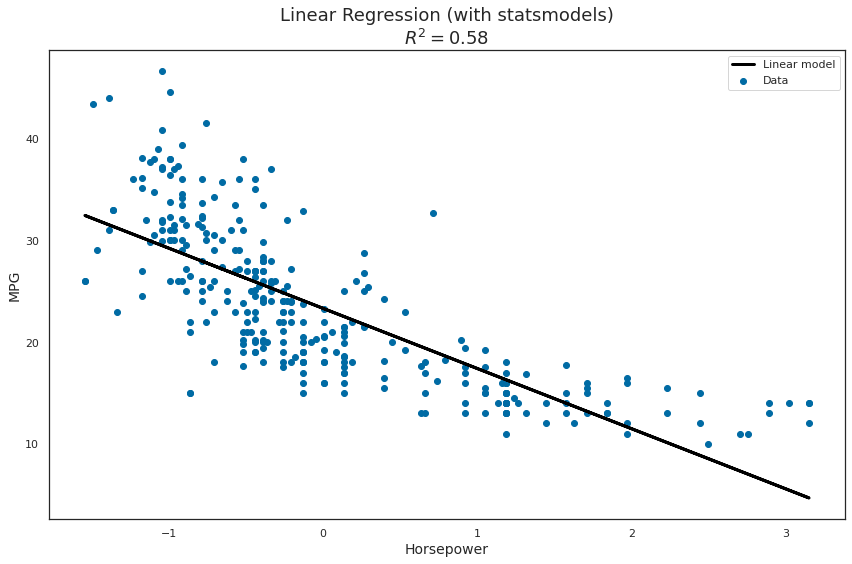

In [ ]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_features['Horsepower'], res_sm.predict(), color='black', linewidth=3, label='Linear model')
ax.scatter(train_features['Horsepower'], train_labels, label='Data')
ax.set_ylabel('MPG', fontsize=14)
ax.set_xlabel('Horsepower', fontsize=14)
ax.set_title('Linear Regression (with statsmodels)\n$R^2= %.2f$' % res_sm.rsquared_adj, fontsize=18)
ax.legend(fontsize=11)

fig.tight_layout();

In [ ]:
X_test = test_features['Horsepower'].values
X_test = sm.add_constant(X_test)

X_test[:10]

array([[ 1.        ,  2.16471127],
       [ 1.        ,  2.78574805],
       [ 1.        ,  2.23923569],
       [ 1.        , -0.19522848],
       [ 1.        , -0.07102113],
       [ 1.        ,  1.79208921],
       [ 1.        ,  1.24557684],
       [ 1.        ,  1.66788185],
       [ 1.        , -0.36911878],
       [ 1.        , -0.84110673]])

In [ ]:
y_preds = res_sm.predict(exog=X_test)

y_preds[:10]

array([10.51943525,  6.84978763, 10.07907754, 24.46409622, 23.73016669,
       12.72122383, 15.95051373, 13.45515335, 25.49159755, 28.28052974])

In [ ]:
test_r2_sm = r2_score(test_labels, y_preds)
print('Test set (aka out-of-sample) R-squared: {:.3f}'.format(test_r2_sm))

Test set (aka out-of-sample) R-squared: 0.669


In [ ]:
test_mse = sm.tools.eval_measures.mse(test_labels, y_preds)
print('Test set (aka out-of-sample) MSE: {:.3f}'.format(test_mse))

Test set (aka out-of-sample) MSE: 21.596


In [ ]:
test_mse_sm = mean_squared_error(test_labels, y_preds)
print('Test set (aka out-of-sample) MSE: {:.3f}'.format(test_mse_sm))

Test set (aka out-of-sample) MSE: 21.596


In [ ]:
test_rmse_sm = mean_squared_error(test_labels, y_preds, squared=False)
print('Test set (aka out-of-sample) RMSE: {:.3f}'.format(test_rmse_sm))

Test set (aka out-of-sample) RMSE: 4.647


### `scikit-learn`

In [ ]:
y = train_labels.values

X = train_features['Horsepower'].values

y[:5], X[:5]

(array([28. , 22.3, 12. , 38. , 33.8]),
 array([-0.78405236, -0.4428111 ,  1.44714046, -1.09904428, -0.99404698]))

In [ ]:
lr = LinearRegression()

res_sk = lr.fit(X.reshape(-1,1), y)

res_sk

LinearRegression()

In [ ]:
coefs = np.concatenate(([np.round(val, 3) for val in res_sk.intercept_.flatten()], 
                        [np.round(val, 3) for val in res_sk.coef_.flatten()]))

ols_coefs = pd.DataFrame.from_dict( dict(zip(['Intercept', 'Horsepower'], coefs)), orient='index')
ols_coefs.columns = ['coef']

ols_coefs

,coef
Intercept,23.311
Horsepower,-5.909


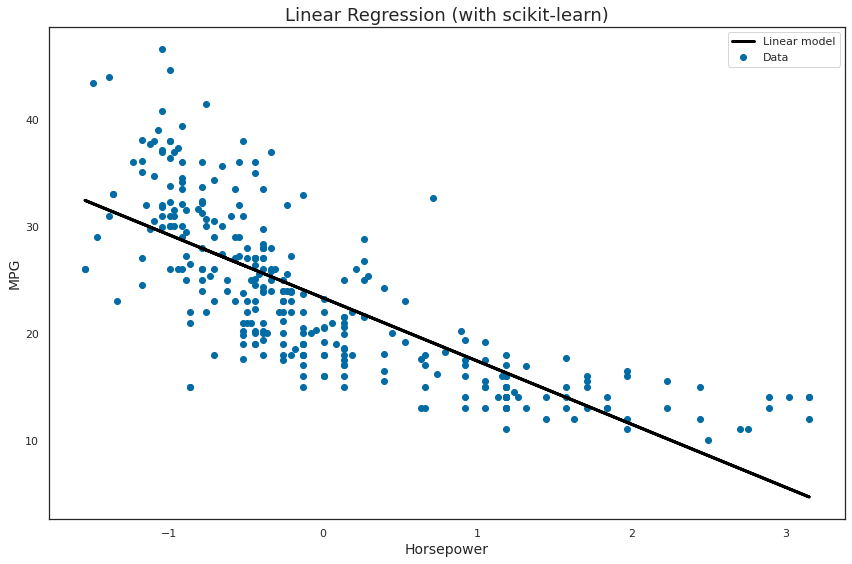

In [ ]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_features['Horsepower'], res_sk.predict(train_features['Horsepower'].values.reshape(-1,1)), color='black', linewidth=3, label='Linear model')
ax.scatter(train_features['Horsepower'], train_labels, label='Data')
ax.set_ylabel('MPG', fontsize=14)
ax.set_xlabel('Horsepower', fontsize=14)
ax.set_title('Linear Regression (with scikit-learn)', fontsize=18)
ax.legend(fontsize=11)

fig.tight_layout();

In [ ]:
X_test = test_features['Horsepower'].values

X_test[:10]

array([ 2.16471127,  2.78574805,  2.23923569, -0.19522848, -0.07102113,
        1.79208921,  1.24557684,  1.66788185, -0.36911878, -0.84110673])

In [ ]:
y_preds = lr.predict(X_test.reshape(-1,1))

y_preds[:10]

array([10.51943525,  6.84978763, 10.07907754, 24.46409622, 23.73016669,
       12.72122383, 15.95051373, 13.45515335, 25.49159755, 28.28052974])

In [ ]:
test_r2_sk = r2_score(test_labels, y_preds)
print('Test set (aka out-of-sample) R-squared: {:.3f}'.format(test_r2_sk))

Test set (aka out-of-sample) R-squared: 0.669


In [ ]:
test_mse = sm.tools.eval_measures.mse(test_labels, y_preds)
print('Test set (aka out-of-sample) MSE: {:.3f}'.format(test_mse))

Test set (aka out-of-sample) MSE: 21.596


In [ ]:
test_mse_sk = mean_squared_error(test_labels, y_preds)
print('Test set (aka out-of-sample) MSE: {:.3f}'.format(test_mse_sk))

Test set (aka out-of-sample) MSE: 21.596


In [ ]:
test_rmse_sk = mean_squared_error(test_labels, y_preds, squared=False)
print('Test set (aka out-of-sample) RMSE: {:.3f}'.format(test_rmse_sk))

Test set (aka out-of-sample) RMSE: 4.647


# Exercise:

## 2a. The relationship between `MPG` and `Horsepower` is visibly curved and the linear model does not appear to fit the data well.  Use `scikit-learn` or `statsmodels` and fit a quadratic model (i.e. $y = x + x^2$) to these data

## 2b. Plot the data and the fitted quadratic model (note the improved fit)

### with `statsmodels`

In [3]:
# Create y from train_labels


# Create X and X**2 from train_features


# Add constant


In [2]:
# Describe model


# Fit model


# Summarize model


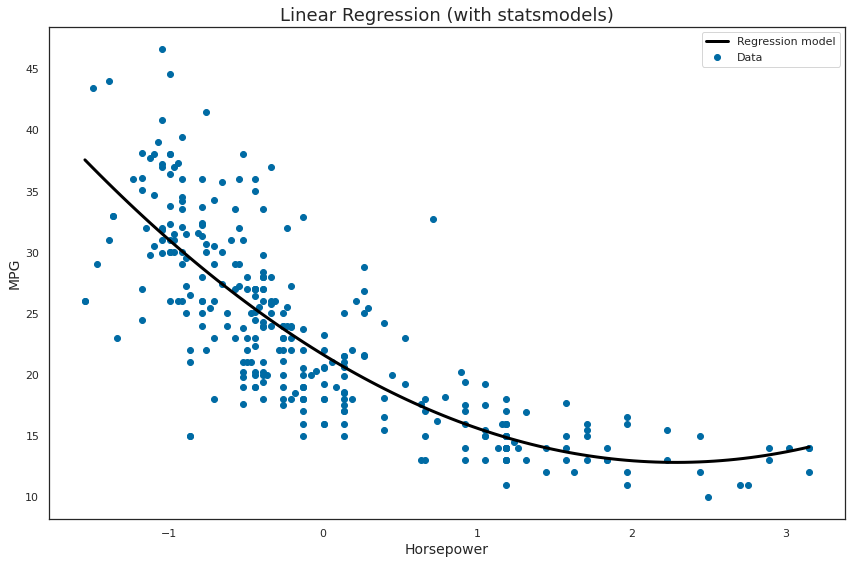

In [ ]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(train_features['Horsepower'].min(), train_features['Horsepower'].max(), 100)
y = <FITTED_MODEL>.predict(pd.DataFrame({'const': 1, 'x1': x, 'x2': x**2}))
f = interp1d(x, y, kind = "quadratic")
xnew = np.linspace(train_features['Horsepower'].min(), train_features['Horsepower'].max(), 100)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(12, 8))

plt.plot()   # Hint: xnew, ynew, linestyle='-', color='black', linewidth=3, label='Regression model'
ax.scatter() # Hint: train_features['Horsepower'], train_labels, label='Data'
ax.set_ylabel('MPG', fontsize=14)
ax.set_xlabel('Horsepower', fontsize=14)
ax.set_title('Linear Regression (with statsmodels)', fontsize=18)
ax.legend(fontsize=11)

fig.tight_layout();

### with `scikit-learn`

In [4]:
# Create y from train_labels


# Create X and X**2 from train_features


# Add constant


In [ ]:
# Describe model


# Fit model


LinearRegression()

In [ ]:
coefs = np.concatenate(([np.round(val, 3) for val in <FITTED_MODEL>.intercept_.flatten()], 
                        [np.round(val, 3) for val in <FITTED_MODEL>.coef_.flatten()]))

ols_coefs = pd.DataFrame.from_dict( dict(zip(['Intercept', 'Horsepower', 'Horsepower**2'], coefs)), orient='index')
ols_coefs.columns = ['coef']

ols_coefs

,coef
Intercept,21.634
Horsepower,-7.700
Horsepower**2,1.682


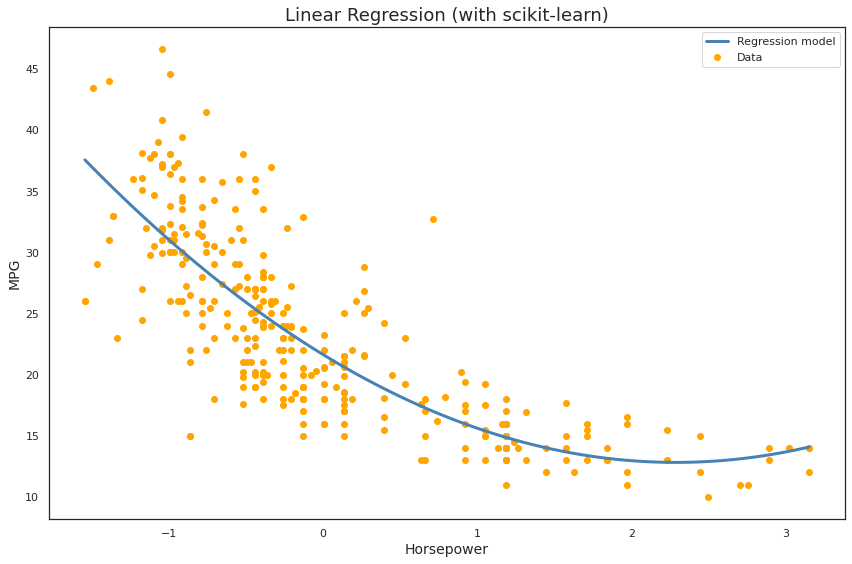

In [ ]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(train_features['Horsepower'].min(), train_features['Horsepower'].max(), 100)
y = <FITTED_MODEL>.predict(pd.DataFrame({'x1': x, 'x2': x**2}))
f = interp1d(x, y, kind = "quadratic")
xnew = np.linspace(train_features['Horsepower'].min(), train_features['Horsepower'].max(), 100)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(12, 8))

plt.plot()   # Hint: xnew, ynew, linestyle='-', color='steelblue', linewidth=3, label='Regression model'
ax.scatter() # Hint: train_features['Horsepower'], train_labels, color='orange', label='Data'
ax.set_ylabel('MPG', fontsize=14)
ax.set_xlabel('Horsepower', fontsize=14)
ax.set_title('Linear Regression (with scikit-learn)', fontsize=18)
ax.legend(fontsize=11)

fig.tight_layout();

### `tensorflow (keras)`

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

- Normalize the `'Horsepower'` input features using the `tf.keras.layers.Normalization` preprocessing layer.

- Apply a linear transformation ($y = mx + b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of *inputs* can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [17]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

In [18]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'MPG'` from `'Horsepower'`.

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_squared_error`) and how (using the `tf.keras.optimizers.Adam`).

In [19]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

Use Keras `Model.fit` to execute the training for 100 epochs:

In [20]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.63 s, sys: 177 ms, total: 3.81 s
Wall time: 3.59 s


Visualize the model's training progress using the stats stored in the `history` object:

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,24.977486,23.914776,95
96,24.975994,23.918711,96
97,25.011240,23.920317,97
98,24.977472,23.894012,98
99,24.977205,23.887730,99


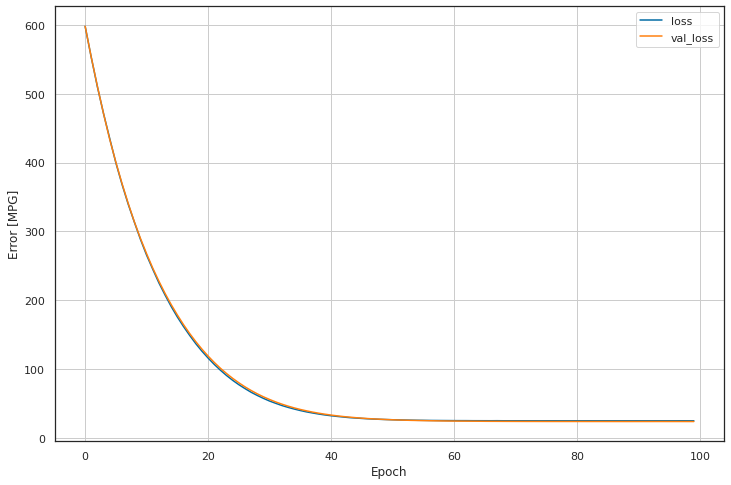

In [22]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True);

Collect the results on the test set for later:

In [23]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

test_results

{'horsepower_model': 20.92015266418457}

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

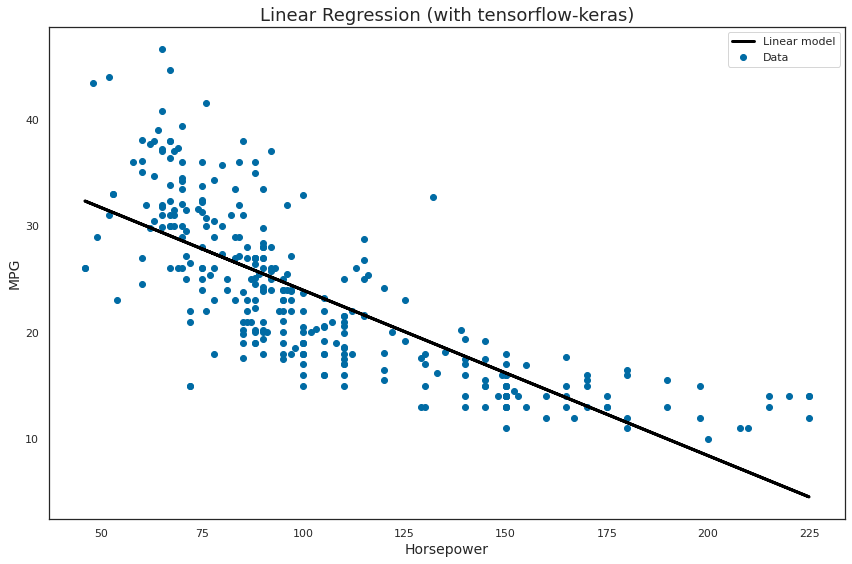

In [24]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_features['Horsepower'], horsepower_model.predict(train_features['Horsepower']), color='black', linewidth=3, label='Linear model')
ax.scatter(train_features['Horsepower'], train_labels, label='Data')
ax.set_ylabel('MPG', fontsize=14)
ax.set_xlabel('Horsepower', fontsize=14)
ax.set_title('Linear Regression (with tensorflow-keras)', fontsize=18)
ax.legend(fontsize=11)

fig.tight_layout();

In [25]:
X_test = test_features['Horsepower'].values

X_test[:10]

array([190, 215, 193,  95, 100, 175, 153, 170,  88,  69])

In [ ]:
y_preds = horsepower_model.predict(X_test.reshape(-1,1))

y_preds[:10]

array([[10.417691 ],
       [ 6.746254 ],
       [ 9.9771185],
       [24.36916  ],
       [23.634872 ],
       [12.620555 ],
       [15.851421 ],
       [13.354842 ],
       [25.397163 ],
       [28.187456 ]], dtype=float32)

In [ ]:
test_r2_tf = r2_score(test_labels, y_preds)
print('Test set (aka out-of-sample) R-squared: {:.3f}'.format(test_r2_tf))

Test set (aka out-of-sample) R-squared: 0.667


In [ ]:
test_mse_tf = mean_squared_error(test_labels, y_preds)
print('Test set (aka out-of-sample) MSE: {:.3f}'.format(test_mse_tf))

Test set (aka out-of-sample) MSE: 21.730


In [ ]:
test_rmse_tf = mean_squared_error(test_labels, y_preds, squared=False)
print('Test set (aka out-of-sample) RMSE: {:.3f}'.format(test_rmse_tf))

Test set (aka out-of-sample) RMSE: 4.662


## Compare `statsmodels`, `scikit-learn`, and `tensorflow`

In [ ]:
pd.DataFrame([[test_r2_sm, test_mse_sm, test_rmse_sm],
              [test_r2_sk, test_mse_sk, test_rmse_sk],
              [test_r2_tf, test_mse_tf, test_rmse_tf]],
             index=['statsmodels', 'scikit-learn', 'tensorflow'],
             columns=['R-squared', 'MSE', 'RMSE']).round(2)

,R-squared,MSE,RMSE
statsmodels,0.67,21.60,4.65
scikit-learn,0.67,21.60,4.65
tensorflow,0.67,21.73,4.66
